- input: aggregated/*.csv
- output: aggregated/figures/*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools  # for cycling through colors if necessary
import glob
import re
import os

In [326]:
num_models = 12 #CHANGE
ep = 'cudaep' #change
#path = f"D:/GAISSA/energy-repo/last_repo/june_{device}/"  # Adjust this path to your CSV files location #CHANGE

path = None
if ep == 'cpuep':
    path = f"D:/GAISSA/energy-repo/repo_sept_last_update/cpuep_nov_results/aggregated/" #
else:
    path = f"D:/GAISSA/energy-repo/repo_sept_last_update/cudaep_nov_results/aggregated/" # 

#save_figs = False
SAVE_FIGS = False
SAVE_TABLES = False
UPDATE_TINY = False

In [327]:
save_dir = path+"figures_no_jit_01/" #change
dir_path_names = ["lvl_2","lvl_2_by_size",'lvl_3_by_size','lvl_4_by_size']
try:
    os.mkdir(save_dir)
    print("Created directory "+ save_dir )
except Exception as e:
    print("could not create directory "+ save_dir )
    print(e)

for dir_name in dir_path_names:
    try:
        os.mkdir(save_dir+dir_name)
        print("Created directory "+ save_dir+dir_name )
    except Exception as e:
        print("could not create directory "+ save_dir+dir_name )
        print(e)



Created directory D:/GAISSA/energy-repo/repo_sept_last_update/cudaep_nov_results/aggregated/figures_no_jit_01/
Created directory D:/GAISSA/energy-repo/repo_sept_last_update/cudaep_nov_results/aggregated/figures_no_jit_01/lvl_2
Created directory D:/GAISSA/energy-repo/repo_sept_last_update/cudaep_nov_results/aggregated/figures_no_jit_01/lvl_2_by_size
Created directory D:/GAISSA/energy-repo/repo_sept_last_update/cudaep_nov_results/aggregated/figures_no_jit_01/lvl_3_by_size
Created directory D:/GAISSA/energy-repo/repo_sept_last_update/cudaep_nov_results/aggregated/figures_no_jit_01/lvl_4_by_size


In [4]:
def remove_condition_rows(condition_to_remove,df):
    # example: condition = merged_df['label']  == 'idle_idle'
    df1 = df.copy()
    return df1[~condition_to_remove]

In [5]:
def save_latex_table(df,save_dir):
    df = df.copy()
    df.columns = [col.replace('_', ' ') for col in df.columns]
    
    latex_table = df.to_latex(index=False)

    # Define the filename
    filename = save_dir
    
    # Open the file in write mode
    with open(filename, 'w') as file:
        file.write(latex_table) if SAVE_TABLES else print(f"SAVE_TABLES:{SAVE_TABLES}")
        
    # Print LaTeX table
    print(latex_table)

## Box plots functions

In [6]:
import matplotlib.colors as mcolors

# Generate a list of 12 colors
def generate_colors(num_colors=12):
    tableau_colors = list(mcolors.TABLEAU_COLORS.values())  # Tableau colors
    extended_colors = list(mcolors.CSS4_COLORS.values())  # CSS4 colors as a backup

    # Ensure distinct colors if num_colors > tableau colors available
    if num_colors > len(tableau_colors):
        tableau_colors += extended_colors[:(num_colors - len(tableau_colors))]

    return tableau_colors[:num_colors]

colors = generate_colors(12)
print(colors)


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#F0F8FF', '#FAEBD7']


In [7]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#F0F8FF', '#FAEBD7']

In [ ]:
def box_plots(data, variables_to_plot, num_models, save=False, save_dir = None, groupedby = 'label'):
    
    # Assuming combined_df is already created and contains the data
    #variables_to_plot = ['diff_CPU_ENERGY (J)', 'avg_diff_CPU_ENERGY (J)', 'avg_TOTAL_MEMORY', 'minus_avg_USED_MEMORY', 'avg_TOTAL_SWAP']
    
    
    
    # Define some colors for the boxes
    #colors = ['blue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'orange', 'yellow', 'cyan']
    #colors=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]
    global colors
    func_colors = colors[:num_models]
    # Make the color list cyclic in case there are more groups than colors
    color_cycle = itertools.cycle(func_colors)
    marker_cycle = itertools.cycle(['o', 's', '^', 'D']) 


    # Generate box plots
    for variable in variables_to_plot:
        plt.figure(figsize=(10, 6))
        
        # Group data by 'label' : runtime_model
        grouped = data.groupby(groupedby)
        
        # We need to know the number of groups
        num_groups = len(grouped)
        
        # Creating a box for each group
        for i, (name, group) in enumerate(grouped):
            # Plot only the part of the data for this group
            # `positions` gives the position of the box in the plot
            if i == 0:
                print(f"datapoints {len(group[variable])}")
            if len(group[variable]) == 1:
                # If only one datapoint, use scatter instead of boxplot
                plt.scatter(group[variable].values, [i], color=next(color_cycle), label=name, s=100,
                           marker = next(marker_cycle))
            else:
                plt.boxplot(group[variable].dropna(), positions=[i], widths=0.6, vert=False, patch_artist=True,
                        boxprops=dict(facecolor=next(color_cycle)))  # Use cyclic color
    
        # Customizing plot
        #plt.title(f'Box Plot of {variable} by Label')
        plt.xlabel(variable)
        plt.xlim([0,data[variable].max()*1.1])
        
        
        #plt.yticks(np.arange(num_groups), grouped.groups.keys())  # Set y-ticks to group names
        print(f"len {len(grouped.groups.keys())}")
        print(f"type {type(grouped.groups.keys())}")
        print(f"value {grouped.groups.keys()}")
        if isinstance(list(grouped.groups.keys())[0],str):
            print("-")
            plt.yticks(np.arange(num_groups), [f"<{ep.upper()}, {label}>" for label in grouped.groups.keys()])
        else:
            plt.yticks(np.arange(num_groups), [f"{label[0]}: <{ep.upper()}, {label[-1].upper()}>" for label in grouped.groups.keys()])
        plt.ylabel('Label')
        plt.grid(True)
        plt.tight_layout()  # Adjust layout to make room for labels
        if save:
            plt.savefig(save_dir+variable)
        else:
            print("Not saved")
    
    plt.show()

In [350]:
def box_plots(data, variables_to_plot, num_models, save=False, save_dir = None, groupedby = 'label'):
    
    # Assuming combined_df is already created and contains the data
    #variables_to_plot = ['diff_CPU_ENERGY (J)', 'avg_diff_CPU_ENERGY (J)', 'avg_TOTAL_MEMORY', 'minus_avg_USED_MEMORY', 'avg_TOTAL_SWAP']

    # Define some colors for the boxes
    #colors = ['blue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'orange', 'yellow', 'cyan']
    #colors=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]
    global colors
    func_colors = colors[:num_models]
    # Make the color list cyclic in case there are more groups than colors
    color_cycle = itertools.cycle(func_colors)

    
    runtime_colors = {
            "torch": '#1f77b4',  # Blue
            "onnx": '#8c564b',  # 
            "ov": '#2ca02c'   # Green
        }
    runtime_markers = {
            "torch": 'o',
             "onnx": 's', 
            "ov": '^',
        }

    if ep == 'cudaep':
        runtime_colors = {
            "torch": '#1f77b4',  # Blue
            "onnx": '#8c564b',  # 
            #"ov": '#2ca02c'   # Green
        }
        runtime_markers = {
                "torch": 'o',
                 "onnx": 's', 
                #"ov": '^',
            }
    if num_models <= 3:
        # Ensure runtime_colors has enough mappings for the given number of models
        unique_runtimes = data[groupedby[-1]].unique()
        if len(unique_runtimes) > len(runtime_colors):
            raise ValueError("Not enough colors provided for the unique runtimes in the data.")

    # Generate box plots
    for variable in variables_to_plot:
        plt.figure(figsize=(10, 6))
        
        # Group data by 'label' : runtime_model
        grouped = data.groupby(groupedby)
        print(f"grouped: {grouped}")
        print(f"enumerate grouped: {enumerate(grouped)}")
        
        # We need to know the number of groups
        num_groups = len(grouped)

        current_size_group = None
        
        # Creating a box for each group
        for i, (name, group) in enumerate(grouped):
            #print(f"{i}, name: {name} group: {group}")
            if num_models <= 3:
                #print(f"color and marker for: {name[-1]}") # (1, onnx)
                color = runtime_colors.get(name[-1], '#cccccc') #default gray
                marker = runtime_markers.get(name[-1], 'o') 
            # Plot only the part of the data for this group
            # `positions` gives the position of the box in the plot
            if i == 0:
                print(f"datapoints {len(group[variable])}")
            if len(group[variable]) == 1:
                # If only one datapoint, use scatter instead of boxplot
                plt.scatter(group[variable].values, [i], color=color, label=name, s=100,
                           marker = marker)
            else:
                if num_models <= 3:
                    plt.boxplot(group[variable].dropna(), positions=[i], widths=0.5, vert=False, patch_artist=True,
                            boxprops=dict(facecolor=color))  # Use cyclic color
                else:
                    plt.boxplot(group[variable].dropna(), positions=[i], widths=0.5, vert=False, patch_artist=True,
                            boxprops=dict(facecolor=next(color_cycle)))  # Use cyclic color
             # Add a horizontal line to separate groups when num_models <= 3

            if num_models <= 3:
                size_group, _ = name
                if current_size_group is None:
                    current_size_group = size_group
                elif size_group != current_size_group:
                    # Draw horizontal line to separate size_group
                    plt.axhline(y=i - 0.5, color='black', linestyle='-', linewidth=1)
                    current_size_group = size_group
            
        
        if num_models <= 3:

            legend_patches = [
                plt.Line2D(
                    [0], [0], 
                    marker=runtime_markers['onnx'], 
                    color=runtime_colors[runtime], 
                    label=runtime, 
                    markersize=8, 
                    linestyle='None'
                ) for runtime in runtime_colors
            ]
            plt.legend(handles=legend_patches, title="Runtime engine", loc='lower right')
            
        # Customizing plot
        #plt.title(f'Box Plot of {variable} by Label')
        plt.xlabel(variable)
        plt.xlim([0,data[variable].max()*1.1])
        
        
        #plt.yticks(np.arange(num_groups), grouped.groups.keys())  # Set y-ticks to group names
        print(f"len {len(grouped.groups.keys())}")
        print(f"type {type(grouped.groups.keys())}")
        print(f"value {grouped.groups.keys()}")
        
        if ep in ["cpu", "cpuep"]:
            provider = "CPU"
        elif ep in ["cuda","cudaep"]:
            provider = "CUDA"
        else:
            print(f"no ep: {ep}")
            
        if isinstance(list(grouped.groups.keys())[0],str):
            print("-")
            plt.yticks(np.arange(num_groups), [f"<{label}, {provider}>" for label in grouped.groups.keys()])
        else:
            #plt.yticks(np.arange(num_groups), [f"{label[0]}: <{label[-1].upper()}, {provider}>" for label in grouped.groups.keys()])
            plt.yticks(np.arange(num_groups), [f"{label[0]}, <{label[-1].upper()}, {provider}>" for label in grouped.groups.keys()])
        plt.ylabel('model size category, serving configuration')
        plt.grid(True)
        plt.tight_layout()  # Adjust layout to make room for labels
        if save:
            plt.savefig(save_dir+variable)
        else:
            print("Not saved")
    
    plt.show()

## config options

In [328]:
path

'D:/GAISSA/energy-repo/repo_sept_last_update/cudaep_nov_results/aggregated/'

In [411]:
names = ['energibridge', 'nvidia', 'energy', 'inference_time'] #change no nvidia for cpuep
from_name = names[3] # energibridge nvidia energy inference_time #change
from_name

'inference_time'

In [412]:

df_ag_02 = pd.read_csv(f'{path}{from_name}_vars_2.csv',index_col=None) 

df_ag_02

,label,experiment,duration,runtime,model,size_group
0,torch_pythia1-4b,1,190.224346,torch,pythia1-4b,2
1,torch_tinyllama,1,188.823235,torch,tinyllama,2
2,torch_codeparrot-small,1,94.157740,torch,codeparrot-small,1
3,torch_pythia-410m,1,189.240295,torch,pythia-410m,1
4,onnx_pythia1-4b,1,535.773089,onnx,pythia1-4b,2
...,...,...,...,...,...,...
355,torch_bloomz-1b1,9,105.085200,torch,bloomz-1b1,2
356,torch_stablecode-3b-completion,9,376.721075,torch,stablecode-3b-completion,3
357,torchscript_starcoderbase-1b,9,94.748692,torchscript,starcoderbase-1b,2
358,torchscript_bloomz-1b1,9,95.861945,torchscript,bloomz-1b1,2


In [413]:
condition = df_ag_02['label'].str.startswith('idle')
df_ag_02 = remove_condition_rows( condition, df_ag_02)
print(len(df_ag_02))
condition = df_ag_02['label'].str.contains('torchscript')
df_ag_02 = remove_condition_rows( condition, df_ag_02)
print(len(df_ag_02))
df_ag_02

360
240


,label,experiment,duration,runtime,model,size_group
0,torch_pythia1-4b,1,190.224346,torch,pythia1-4b,2
1,torch_tinyllama,1,188.823235,torch,tinyllama,2
2,torch_codeparrot-small,1,94.157740,torch,codeparrot-small,1
3,torch_pythia-410m,1,189.240295,torch,pythia-410m,1
4,onnx_pythia1-4b,1,535.773089,onnx,pythia1-4b,2
...,...,...,...,...,...,...
352,onnx_bloomz-1b1,9,1029.394496,onnx,bloomz-1b1,2
353,onnx_stablecode-3b-completion,9,1027.841333,onnx,stablecode-3b-completion,3
354,torch_starcoderbase-1b,9,189.910654,torch,starcoderbase-1b,2
355,torch_bloomz-1b1,9,105.085200,torch,bloomz-1b1,2


In [414]:
df_ag_02.columns

Index(['label', 'experiment', 'duration', 'runtime', 'model', 'size_group'], dtype='object')

In [415]:
df_ag_03 = pd.read_csv(f'{path}{from_name}_vars_3.csv',index_col=None) #change
df_ag_04 = pd.read_csv(f'{path}{from_name}_vars_4.csv',index_col=None) #change

In [416]:
condition = df_ag_03['label'].str.startswith('idle')
df_ag_03 = remove_condition_rows( condition, df_ag_03)
print(len(df_ag_03))
condition = df_ag_03['label'].str.contains('torchscript')
df_ag_03 = remove_condition_rows( condition, df_ag_03)
print(len(df_ag_03))
df_ag_03

36
24


,label,duration,runtime,model,size_group
0,onnx_bloomz-1b1,1029.257360,onnx,bloomz-1b1,2
1,onnx_bloomz-560m,225.435832,onnx,bloomz-560m,1
2,onnx_codegemma-2b,678.768990,onnx,codegemma-2b,3
3,onnx_codeparrot-small,191.048335,onnx,codeparrot-small,1
4,onnx_phi2,793.478886,onnx,phi2,3
5,onnx_pythia-410m,447.527716,onnx,pythia-410m,1
6,onnx_pythia1-4b,535.354030,onnx,pythia1-4b,2
7,onnx_stablecode-3b,617.516664,onnx,stablecode-3b,3
8,onnx_stablecode-3b-completion,964.568877,onnx,stablecode-3b-completion,3
9,onnx_starcoderbase-1b,556.800123,onnx,starcoderbase-1b,2


In [417]:
df_ag_04.columns

Index(['size_group', 'runtime', 'duration'], dtype='object')

In [418]:
condition = df_ag_04['runtime'].str.contains('torchscript')
df_ag_04 = remove_condition_rows( condition, df_ag_04)
print(len(df_ag_04))
df_ag_04

6


,size_group,runtime,duration
0,1,onnx,277.122695
1,1,torch,124.034311
3,2,onnx,630.643419
4,2,torch,168.744052
6,3,onnx,763.583355
7,3,torch,260.619052


In [419]:
path

'D:/GAISSA/energy-repo/repo_sept_last_update/cudaep_nov_results/aggregated/'

In [420]:
from_name

'inference_time'

In [421]:
save_dir

'D:/GAISSA/energy-repo/repo_sept_last_update/cudaep_nov_results/aggregated/figures_no_jit_01/'

grouped: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x0000028D2A314F10>
enumerate grouped: <enumerate object at 0x0000028D29BB0F80>
datapoints 10
len 24
type <class 'dict_keys'>
value dict_keys(['onnx_bloomz-1b1', 'onnx_bloomz-560m', 'onnx_codegemma-2b', 'onnx_codeparrot-small', 'onnx_phi2', 'onnx_pythia-410m', 'onnx_pythia1-4b', 'onnx_stablecode-3b', 'onnx_stablecode-3b-completion', 'onnx_starcoderbase-1b', 'onnx_tiny-starcoder', 'onnx_tinyllama', 'torch_bloomz-1b1', 'torch_bloomz-560m', 'torch_codegemma-2b', 'torch_codeparrot-small', 'torch_phi2', 'torch_pythia-410m', 'torch_pythia1-4b', 'torch_stablecode-3b', 'torch_stablecode-3b-completion', 'torch_starcoderbase-1b', 'torch_tiny-starcoder', 'torch_tinyllama'])
-


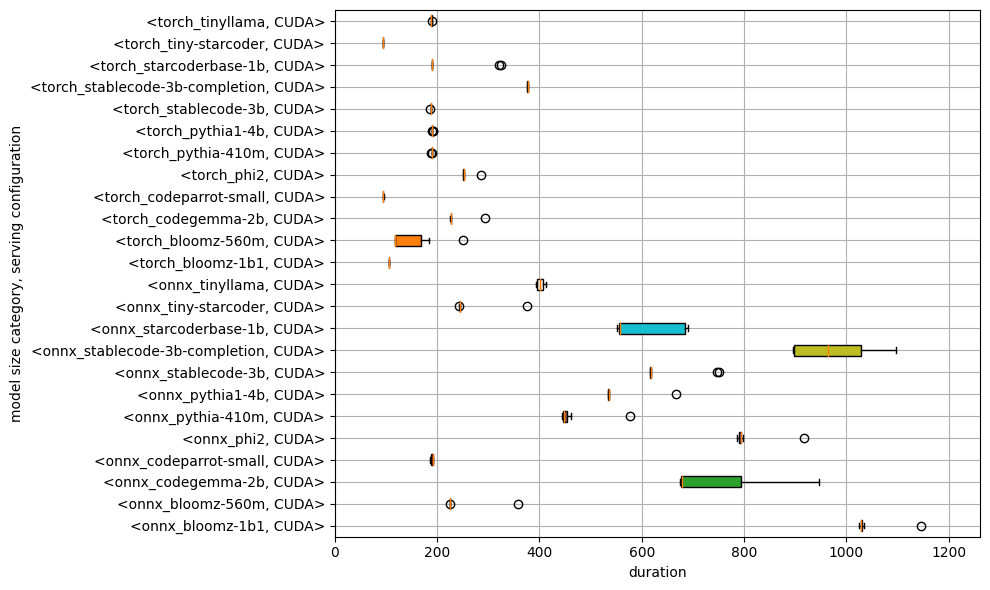

In [422]:
if from_name == 'energibridge':
    variables_to_plot = ['avg_cpu_usage_config','avg_used_memory_pct_config']
elif from_name == 'energy' and ep == 'cudaep':
    variables_to_plot = ['global_energy']
elif from_name == 'energy' and ep == 'cpuep':
    variables_to_plot = ['global_energy',]
elif from_name == 'nvidia':
    variables_to_plot = ['avg_utilization_gpu_config','avg_utilization_memory_config','avg_used_memory_pct_mib']
elif from_name == 'inference_time':
    variables_to_plot = ['duration']

box_plots(df_ag_02,variables_to_plot, 12, save = True,save_dir = save_dir + "lvl_2/")

In [423]:
df_ag_02.columns

Index(['label', 'experiment', 'duration', 'runtime', 'model', 'size_group'], dtype='object')

In [424]:
df_ag_03.columns

Index(['label', 'duration', 'runtime', 'model', 'size_group'], dtype='object')

In [425]:
ep

'cudaep'

grouped: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x0000028D2BAA0D30>
enumerate grouped: <enumerate object at 0x0000028D2BACCE40>
datapoints 40
len 6
type <class 'dict_keys'>
value dict_keys([(1, 'onnx'), (1, 'torch'), (2, 'onnx'), (2, 'torch'), (3, 'onnx'), (3, 'torch')])


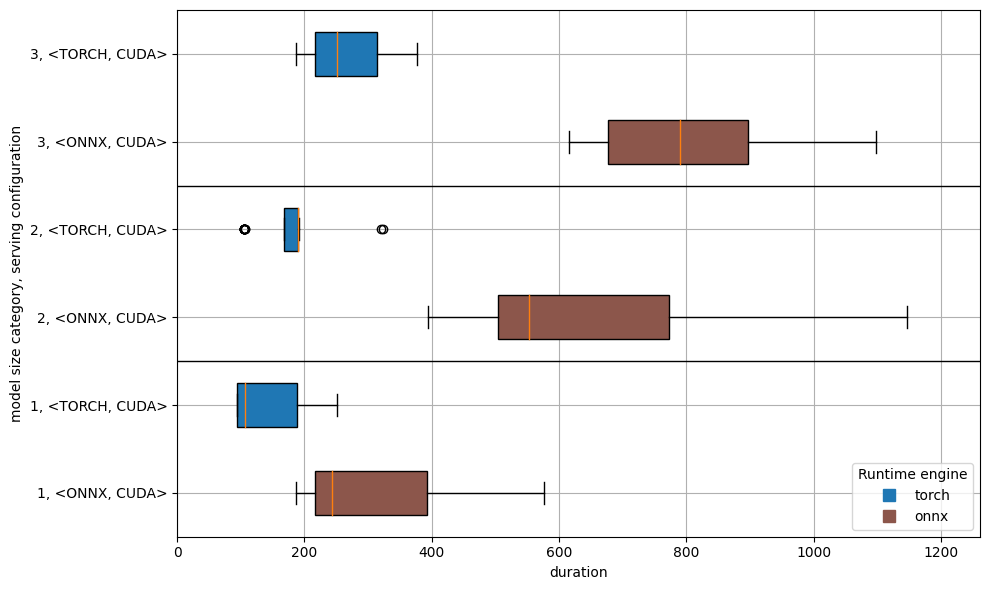

In [426]:
if ep == 'cpuep':
    box_plots(df_ag_02,variables_to_plot, num_models = 3, save = True, # 3 if cudaep, 2 cudaep no jit
          save_dir = save_dir + "lvl_2_by_size/",groupedby=['size_group','runtime'])
elif ep == 'cudaep':
    box_plots(df_ag_02,variables_to_plot, num_models = 2, save = True, # 3 if cudaep, 2 cudaep no jit
          save_dir = save_dir + "lvl_2_by_size/",groupedby=['size_group','runtime'])




grouped: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x0000028D2A3B5F70>
enumerate grouped: <enumerate object at 0x0000028D2B632600>
datapoints 4
len 6
type <class 'dict_keys'>
value dict_keys([(1, 'onnx'), (1, 'torch'), (2, 'onnx'), (2, 'torch'), (3, 'onnx'), (3, 'torch')])


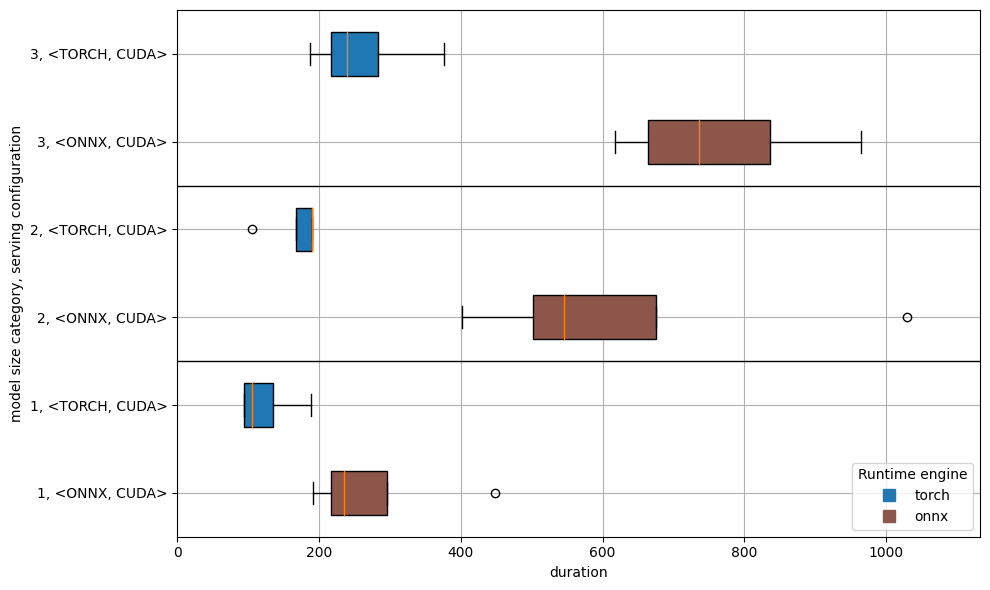

In [427]:
if ep == 'cpuep':
    box_plots(df_ag_03,variables_to_plot, num_models = 3, save = True, # 3 if cudaep, 2 cudaep no jit
          save_dir = save_dir + "lvl_3_by_size/",groupedby=['size_group','runtime'])
elif ep == 'cudaep':
    box_plots(df_ag_03,variables_to_plot, num_models = 2, save = True, # 3 if cudaep, 2 cudaep no jit
          save_dir = save_dir + "lvl_3_by_size/",groupedby=['size_group','runtime'])


In [428]:
df_ag_04.columns

Index(['size_group', 'runtime', 'duration'], dtype='object')

In [429]:
df_ag_04

,size_group,runtime,duration
0,1,onnx,277.122695
1,1,torch,124.034311
3,2,onnx,630.643419
4,2,torch,168.744052
6,3,onnx,763.583355
7,3,torch,260.619052


grouped: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x0000028D2B395FD0>
enumerate grouped: <enumerate object at 0x0000028D2A332400>
datapoints 1
len 6
type <class 'dict_keys'>
value dict_keys([(1, 'onnx'), (1, 'torch'), (2, 'onnx'), (2, 'torch'), (3, 'onnx'), (3, 'torch')])


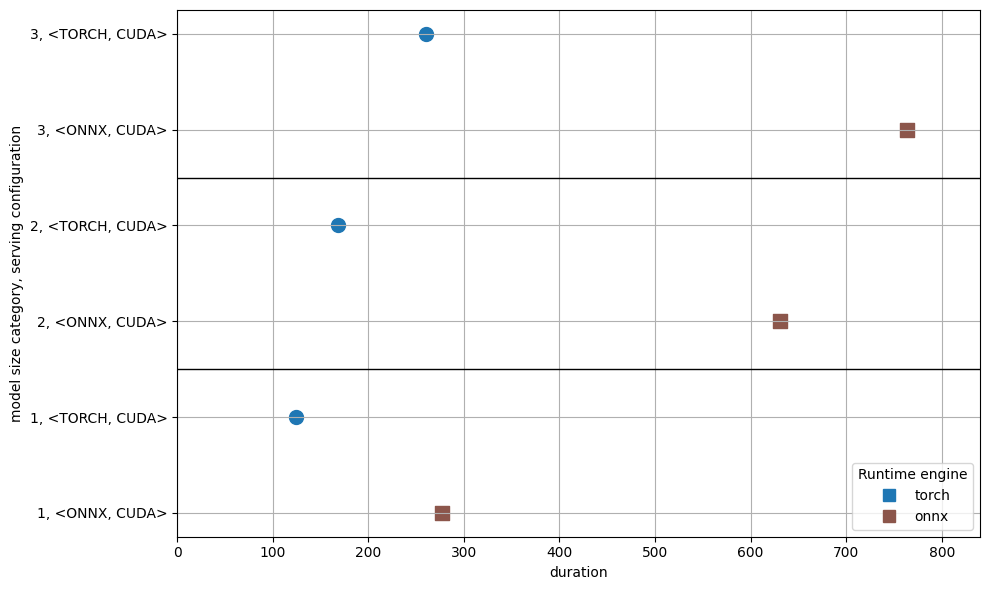

In [430]:
if ep == 'cpuep':
    box_plots(df_ag_04,variables_to_plot, num_models = 3, save = True, # 3 if cudaep, 2 cudaep no jit
          save_dir = save_dir + "lvl_4_by_size/",groupedby=['size_group','runtime'])
elif ep == 'cudaep':
    box_plots(df_ag_04,variables_to_plot, num_models = 2, save = True, # 3 if cudaep, 2 cudaep no jit
          save_dir = save_dir + "lvl_4_by_size/",groupedby=['size_group','runtime'])
